In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
MAGIC = (-80538738812075974) ** 3 + 80435758145817515 ** 3 + 12602123297335631 ** 3
np.random.seed(MAGIC)
torch.manual_seed(MAGIC)
torch.cuda.manual_seed(MAGIC)

In [3]:
device = 'cuda:1'

In [4]:
columns_config = {
    'numerical': ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 
                 'sea_level_pressure', 'wind_speed'
#                   , 'mean_target'
                 ],
    'categorical': [
#         'site_id', 
#         'building_id',
        'primary_use', 
        'wind_direction_cat', 'month', 'hour', 'season', 'daytime']
}

In [5]:
class Net(nn.Module):
    def __init__(self, d_in=10, k=2, n_hidden=1, batch_norm=False, dropout=False):
        super(Net, self).__init__()
        d_cur = d_in
        self.layers = []
        for i in range(n_hidden):
            self.layers.append(nn.Linear(d_cur, d_cur // k))
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(d_cur // k))
            self.layers.append(nn.ReLU())
            if dropout:
                self.layers.append(nn.Dropout())
            d_cur //= k
        self.layers.append(nn.Linear(d_cur, 1))
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
# Utils

# Prepare data

def select_meter(df, meter=1):
    df = df[df.meter == meter]
    df.drop(columns='meter', inplace=True)
    return df

def filter_wind(weather_df):
    weather_df.loc[weather_df.wind_direction + weather_df.wind_speed == 0, ['wind_direction', 'wind_speed']] = np.NaN
    return weather_df

def merge(data, weather, meta):
    df = meta.merge(data, on='building_id')
    df = df.merge(weather, on=['site_id', 'timestamp'])
    return df

def filter_zero_targets(df):
    df = df[df.meter_reading != 0]
    return df

def create_new_features(df):
    df['month'] = df.timestamp.apply(lambda x: time.strptime(x ,"%Y-%m-%d %H:%M:%S").tm_mon)
    df['hour'] = df.timestamp.apply(lambda x: time.strptime(x ,"%Y-%m-%d %H:%M:%S").tm_hour)
    
    df['season'] = df['month'] % 12 // 3
    df['daytime'] = df['hour'] // 5    
    return df

def prepare_data(meter=1, fast_debug=False):
    meta = pd.read_csv('data/building_metadata.csv')
    train = pd.read_csv('data/train.csv')
    weather = pd.read_csv('data/weather_train.csv')
    
    train = select_meter(train, meter)
    weather = filter_wind(weather)
    df = merge(train, weather, meta)
    
    if fast_debug:
        # building_ids = [1109, 1130, 1363, 1377]
        site_ids = np.random.choice(df.site_id.unique(), 5, replace=False)
        df = df[df.site_id.isin(site_ids)]

    df = filter_zero_targets(df)
    df = create_new_features(df)
    return df

def prepare_test_data(train_df, meter=1):
    meta = pd.read_csv('data/building_metadata.csv')
    test = pd.read_csv('data/test.csv')
    weather = pd.read_csv('data/weather_test.csv')
    
    test = select_meter(test, meter)
    weather = filter_wind(weather)
    df = merge(test, weather, meta)
    
    site_ids = train_df.site_id.unique()
    df = df[df.site_id.isin(site_ids)]

    df['meter_reading'] = np.NaN
    df = create_new_features(df)
    return df

# def filter_building(building_id):
#     return df[df.building_id == building_id]
    
def save_results(submission, name):
    with open('results/%s.pkl' % name,'wb') as f:
        pickle.dump(submission, f)
    
    
# Preprocess data
class Preprocessor:
    def __init__(self, df):
        self.df = df
        
        self.train_idx = self.train_test_split()
#         self.df = self.create_mean_target()
        self.df = self.fill_nans()
        self.df = self.create_wind_cat()
        
    def train_test_split(self):
        if 'row_id' in self.df.columns:
            train_idx = self.df[~pd.isna(self.df.meter_reading)].index
            
        else:
            train_idx = np.random.choice(self.df.index, len(self.df) * 7 // 10, replace=False)
        return train_idx
        
    def create_mean_target(self):
        mean_targets = pd.DataFrame(data=self.df[self.df.index.isin(self.train_idx)].groupby('building_id').meter_reading.mean())
        mean_targets.columns = ['mean_target']
        
        self.df['tmp_index'] = self.df.index
        self.df.index = self.df.building_id
        self.df['mean_target'] = mean_targets
        self.df.index = self.df.tmp_index
        
        return self.df
    
    def fill_nans(self):
        for col in ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 
                    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']:
            self.df[col] = self.df[col].fillna(self.df.loc[self.train_idx, col].mean())
            self.df[col] = self.df[col].fillna(0)  # make sure we have no NaNs
        return self.df
    
    def create_wind_cat(self):
        self.df['wind_direction_cat'] = self.df['wind_direction'] // 45
        return self.df

# Scale data
class Scaler:
    def __init__(self, preprocessor, batch_size=512, prod=False):
        self.df = preprocessor.df
        self.train_idx = preprocessor.train_idx
        
        self.scaler_labels = None
        self.scaler_features = None
        self.encoders = {}
        
        self.create_scalers()
        
        cat_train, num_train, labels_train = self.transform(self.df.loc[self.train_idx])
        cat_test, num_test, labels_test = self.transform(self.df[~self.df.index.isin(self.train_idx)])
        self.d_in = cat_train.shape[1] + num_train.shape[1]
        
        if prod:
            self.testloader = torch.FloatTensor(np.concatenate([cat_test, num_test], axis=1)), self.df[~self.df.index.isin(self.train_idx)].row_id
        else:
            self.testloader = self.create_dataloader(cat_test, num_test, labels_test, batch_size)
        self.trainloader = self.create_dataloader(cat_train, num_train, labels_train, batch_size)
  
    def create_scalers(self):
        self.scaler_features = StandardScaler()
        self.scaler_labels = StandardScaler()

        self.scaler_features.fit(self.df.loc[self.train_idx, columns_config['numerical']])
        self.scaler_labels.fit(self.df.loc[self.train_idx, 'meter_reading'].values.reshape(-1, 1))
        for col in columns_config['categorical']:
            self.encoders[col] = OneHotEncoder(handle_unknown='ignore', sparse=False)
            self.encoders[col].fit(self.df.loc[self.train_idx, col].values.reshape(-1, 1))
        
    def transform(self, data):
        num_features = self.scaler_features.transform(data.loc[:, columns_config['numerical']])
        labels = self.scaler_labels.transform(data.loc[:, 'meter_reading'].values.reshape(-1, 1))
        cat_features = []
        for col in columns_config['categorical']:
            cat_features.append(self.encoders[col].transform(data[col].values.reshape(-1, 1)))
        cat_features = np.concatenate(cat_features, axis=1)
        return cat_features, num_features, labels
    
    @staticmethod
    def create_dataloader(cat, num, labels, batch_size, shuffle=True, add_row_ids=False, row_ids=None):
        data = [cat, num]
        if add_row_ids:
            data.append(row_ids.astype(int))
        dataset = TensorDataset(torch.Tensor(np.concatenate(data, 1)).to(device), torch.Tensor(labels).to(device))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return dataloader
    
# Train
class Trainer:
    def __init__(self, scaler, net_config, lr=0.001):
        self.trainloader = scaler.trainloader
        self.testloader = scaler.testloader
        self.scaler_labels = scaler.scaler_labels

        self.optimizer = None
        self.criterion = None
        self.net = None
        
        net_config['d_in'] = scaler.d_in
        self.create_models(net_config, lr)
        
        self.train_losses = []
        self.test_losses = []
        self.metrics = []
        
    def create_models(self, net_config, lr):
        self.net = Net(**net_config).to(device)
#         print('Net architecture:')
#         print(self.net)
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
    
    def metric(self, pred, labels):
        pred_raw = self.scaler_labels.inverse_transform(pred.detach().cpu().numpy())
        labels_raw = self.scaler_labels.inverse_transform(labels.detach().cpu().numpy())
        pred_raw[pred_raw < 0] = 0
        loss =  np.mean((np.log(pred_raw + 1) - np.log(labels_raw + 1)) ** 2) ** 0.5
        return loss
    
    def train(self, n_epochs, verbose=True, do_val=True):
        for epoch in range(n_epochs):
            self.net.train()
            losses = []
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                if inputs.size(0) <= 1:
                    continue
                inputs = inputs.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
            if verbose:
                print('[%d] Train loss: %.3f' % (epoch + 1, np.mean(losses)))
            self.train_losses.append(np.mean(losses))

            if do_val:
                self.net.eval()
                losses = []
                metrics = []
                for i, data in enumerate(self.testloader, 0):
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    with torch.no_grad():
                        outputs = self.net(inputs)
                    if np.isnan(outputs.sum().item()):
                        continue
                    loss = self.criterion(outputs, labels)
                    losses.append(loss.item())
                    metrics.append(self.metric(outputs, labels))
                if verbose:
                    print('[%d] Test loss: %.3f' % (epoch + 1, np.mean(losses)))
                    print('[%d] Test metric: %.3f' % (epoch + 1, np.mean(metrics)))
                self.test_losses.append(np.mean(losses))
                self.metrics.append(np.mean(metrics))
                
    def predict(self, submission):
        self.net.eval()
        inputs, row_ids = self.testloader
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = self.net(inputs)
        pred_raw = self.scaler_labels.inverse_transform(outputs.detach().cpu().numpy())
        pred_raw[pred_raw < 0] = 0
        submission = np.concatenate([submission, 
                                     np.concatenate([row_ids.values.reshape(-1, 1), pred_raw], axis=1)
                                    ], axis=0)
        print(submission[:, 0].shape, np.unique(submission[:, 0]).shape)
#         print(17811060 in row_ids)
#         print(17811060.0 in row_ids)
#         print(26118284 in row_ids)
#         print(26118284. in row_ids)
        return submission

    def plot(self):
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
        ax1.plot(self.train_losses, color='b')
        ax1.plot(self.test_losses, color='y')
        ax2.plot(self.metrics, color='y')
        plt.show()
        
    def save_model(self, name):
        torch.save(self.net, 'models/' + name)
        

In [ ]:
for j in range(3):
    df = prepare_data(meter=j, fast_debug=False)
    test_df = prepare_test_data(df, meter=j)
    df['row_id'] = np.NaN
    df_all = pd.concat([df, test_df], axis=0)
    df_all = df_all.reset_index()
    site_ids = df.site_id.unique()
    submission = np.array([]).reshape(-1, 2)
    for site_id in site_ids:
        df_b = df_all[df_all.site_id == site_id]
        if len(df_b.row_id.value_counts()) == 0:
            continue
        preprocessor = Preprocessor(df_b)
        scaler = Scaler(preprocessor, prod=True)
        trainer = Trainer(scaler, net_config, lr=0.0005)
        trainer.train(20, verbose=False, do_val=False)
        submission = trainer.predict(submission)
        save_results(submission, 'res_%d' % j)
        print('Saved for site %d' % site_id)
    del df_all, df, test_df

In [8]:
df = prepare_data(meter=0, fast_debug=False)
test_df = prepare_test_data(df, meter=0)
df['row_id'] = np.NaN
df_all = pd.concat([df, test_df], axis=0)
df_all = df_all.reset_index()
# check_fuckup(df_all)

KeyboardInterrupt: 

In [9]:
site_ids = df.site_id.unique()
site_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [10]:
submission = np.array([]).reshape(-1, 2)

In [7]:
net_config = {
    'n_hidden': 2,
    'batch_norm': True,
    'dropout': True,
    'k': 3
}

In [14]:
for site_id in site_ids:
    df_b = df_all[df_all.site_id == site_id]
    if len(df_b.row_id.value_counts()) == 0:
        continue
    preprocessor = Preprocessor(df_b)
    scaler = Scaler(preprocessor, prod=True)
    trainer = Trainer(scaler, net_config, lr=0.0005)
    trainer.train(20, verbose=False, do_val=False)
    submission = trainer.predict(submission)
    save_results(submission, 'res_0')
    print('Saved for site %d' % site_id)

(1839600,) (1839600,)
Saved for site 0


KeyboardInterrupt: 

In [18]:
submission[:, 0].shape, np.unique(submission[:, 0]).shape

((207444,), (207444,))

In [62]:
preprocessor = Preprocessor(df[df.site_id == 0])
scaler = Scaler(preprocessor, prod=False)

In [63]:
net_config = {
    'n_hidden': 2,
    'batch_norm': True,
    'dropout': True,
    'k': 3
}
trainer = Trainer(scaler, net_config, lr=0.0005)
trainer.train(20, verbose=True, do_val=True)

[1] Train loss: 1.092
[1] Test loss: 0.732
[1] Test metric: 1.345
[2] Train loss: 0.806
[2] Test loss: 0.541
[2] Test metric: 1.196
[3] Train loss: 0.670
[3] Test loss: 0.416
[3] Test metric: 1.126
[4] Train loss: 0.600
[4] Test loss: 0.360
[4] Test metric: 1.091
[5] Train loss: 0.552
[5] Test loss: 0.314
[5] Test metric: 1.068
[6] Train loss: 0.515
[6] Test loss: 0.280
[6] Test metric: 1.046
[7] Train loss: 0.491
[7] Test loss: 0.275
[7] Test metric: 1.034
[8] Train loss: 0.471
[8] Test loss: 0.250
[8] Test metric: 1.010
[9] Train loss: 0.459
[9] Test loss: 0.236
[9] Test metric: 0.995
[10] Train loss: 0.449
[10] Test loss: 0.237
[10] Test metric: 0.990
[11] Train loss: 0.435
[11] Test loss: 0.224
[11] Test metric: 0.983
[12] Train loss: 0.430
[12] Test loss: 0.212
[12] Test metric: 0.977
[13] Train loss: 0.422
[13] Test loss: 0.217
[13] Test metric: 0.962
[14] Train loss: 0.418
[14] Test loss: 0.216
[14] Test metric: 0.944
[15] Train loss: 0.420
[15] Test loss: 0.208
[15] Test metric

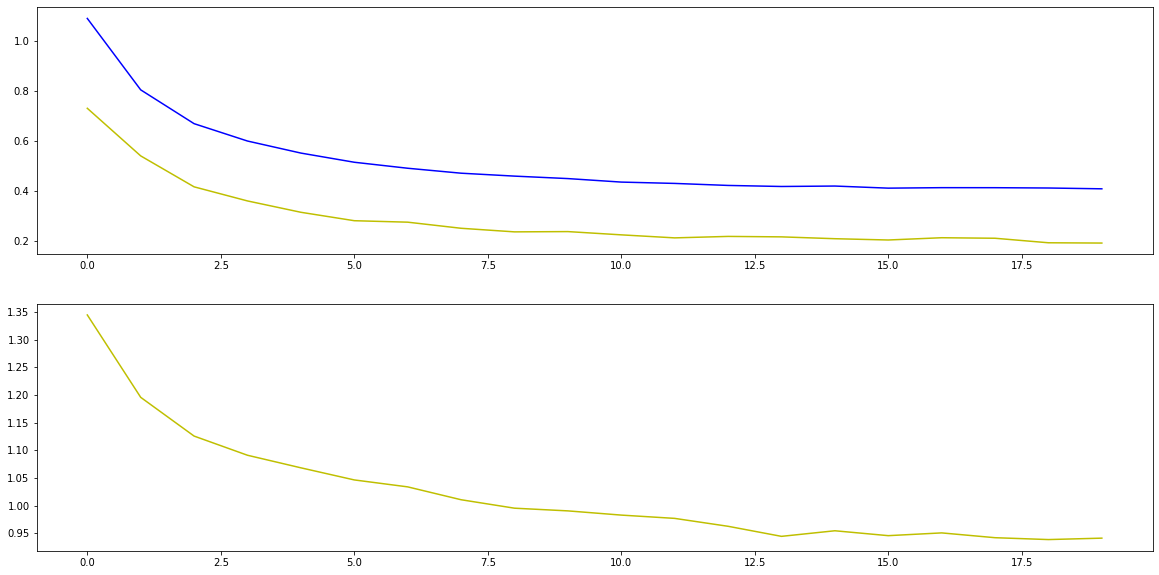

In [64]:
trainer.plot()

In [10]:
submission = np.array([]).reshape(-1, 2)

In [11]:
for building_id in building_ids:
    df_b = df_all[df_all.building_id == building_id]
    preprocessor = Preprocessor(df_b)
    scaler = Scaler(preprocessor, prod=True)
    trainer = Trainer(scaler, net_config, lr=0.0005)
    trainer.train(20, verbose=False, do_val=False)
    submission = trainer.predict(submission)
    save_results(submission, 'res_3')
    print('Saved for building %d' % building_id)

Saved for building 112
Saved for building 113
Saved for building 114
Saved for building 117
Saved for building 119
Saved for building 121
Saved for building 138
Saved for building 144
Saved for building 145
Saved for building 106
Saved for building 139
Saved for building 109
Saved for building 163
Saved for building 166
Saved for building 167
Saved for building 168
Saved for building 169
Saved for building 171
Saved for building 175
Saved for building 177
Saved for building 179
Saved for building 183
Saved for building 184
Saved for building 190
Saved for building 191
Saved for building 192
Saved for building 195
Saved for building 200
Saved for building 201
Saved for building 202
Saved for building 203
Saved for building 206
Saved for building 209
Saved for building 210
Saved for building 212
Saved for building 213
Saved for building 215
Saved for building 216
Saved for building 217
Saved for building 220
Saved for building 221
Saved for building 224
Saved for building 225
Saved for b

In [12]:
submission.shape

(5639006, 2)

In [77]:
with open('results/res.pkl','wb') as f:
    pickle.dump(submission, f)

In [13]:
with open('results/res_1.pkl','rb') as f:
    x = pickle.load(f)
    print(x.shape)
    print(x)

(8681371, 2)
[[8.00000000e+00 1.02568750e+03]
 [1.37000000e+02 1.00599683e+03]
 [2.66000000e+02 1.08562573e+03]
 ...
 [4.14980120e+07 2.89191461e+00]
 [4.14982640e+07 3.09021425e+00]
 [4.14985120e+07 2.82611537e+00]]
